In [1]:
# 导入核心库
import numpy as np
import matplotlib.pyplot as plt
import os
import time # 用于计时

# 导入 TensorFlow (Keras) 来加载 MNIST 数据集
# 实验环境要求，这是最简单的方式
try:
    from tensorflow.keras.datasets import mnist
except ImportError:
    print("TensorFlow 未安装。请在 Anaconda Prompt 中运行:")
    print("pip install tensorflow")

# 导入 sklearn 中需要的模块
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # 主成分分析
from sklearn.svm import SVC # SVM 分类器
from sklearn.metrics import accuracy_score

# 设置 matplotlib 在 notebook 中内嵌显示图像
%matplotlib inline

# (推荐) 解决 matplotlib 中文显示乱码的问题
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# --- 1.1 加载并筛选 1000 个样本 ---

# 1. 加载完整的 MNIST 数据集 (60k 训练 + 10k 测试)
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# 2. 合并训练集和测试集，以便我们有足够的数据可选
X_full = np.concatenate((X_train_full, X_test_full), axis=0)
y_full = np.concatenate((y_train_full, y_test_full), axis=0)

print(f"完整数据集形状: X={X_full.shape}, y={y_full.shape}")

# 3. 筛选 1000 个样本 (每类 100 个)
X_samples = []
y_samples = []

for digit in range(10): # 循环数字 0 到 9
    # 1. 找到当前数字的所有索引
    indices = np.where(y_full == digit)[0]
    
    # 2. 随机抽取 100 个 (或只取前 100 个，这里我们取前 100 个)
    digit_indices = indices[:100]
    
    # 3. 添加到我们的列表中
    X_samples.append(X_full[digit_indices])
    y_samples.append(y_full[digit_indices])

# 4. 将列表合并回 numpy 数组
X_data = np.concatenate(X_samples, axis=0)
y_data = np.concatenate(y_samples, axis=0)

print(f"筛选后样本形状: X={X_data.shape}, y={y_data.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
完整数据集形状: X=(70000, 28, 28), y=(70000,)
筛选后样本形状: X=(1000, 28, 28), y=(1000,)


In [3]:
# --- 1.2 展平、切分与标准化 ---

# 1. 将图像展平 (从 (1000, 28, 28) 变为 (1000, 784))
n_samples = X_data.shape[0]
X_flat = X_data.reshape(n_samples, -1) # -1 会自动计算为 784

print(f"展平后 X 形状: {X_flat.shape}")

# 2. 划分训练集和测试集 (70% / 30%)
# 我们对这 1000 个样本进行切分
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_data, test_size=0.3, random_state=42, stratify=y_data
)

print(f"训练集: {X_train.shape[0]} 样本, 测试集: {X_test.shape[0]} 样本")

# 3. 特征标准化 (非常重要！PCA 对尺度敏感)
scaler = StandardScaler()

# 仅在训练集上 fit
X_train_scaled = scaler.fit_transform(X_train)
# 在测试集上 transform
X_test_scaled = scaler.transform(X_test)

print("数据标准化完成。")

展平后 X 形状: (1000, 784)
训练集: 700 样本, 测试集: 300 样本
数据标准化完成。


正在拟合 PCA (使用全部 700 个训练样本)...
保留 95% 的方差需要 169 个主成分。


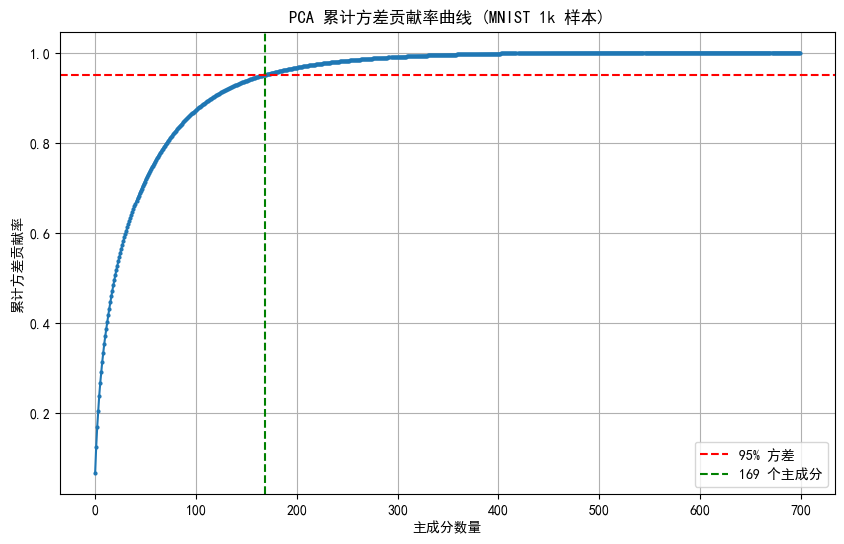

In [4]:
# --- 2. PCA 降维与方差分析 ---

# 1. 初始化 PCA
# n_components=None 意味着保留所有主成分 (在这个例子中是 700 个)
# 以便我们分析方差贡献
pca_full = PCA(n_components=None, random_state=42)

# 2. 在标准化的训练集上拟合 PCA
print("正在拟合 PCA (使用全部 700 个训练样本)...")
pca_full.fit(X_train_scaled)

# 3. 计算累计方差贡献率
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 4. 找到保留 95% 方差所需的主成分数
# np.argmax 会返回第一个 True (>= 0.95) 的索引
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 # +1 因为索引从0开始

print(f"保留 95% 的方差需要 {n_components_95} 个主成分。")

# 5. 绘制累计方差贡献率曲线
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='.', markersize=4)
plt.title('PCA 累计方差贡献率曲线 (MNIST 1k 样本)')
plt.xlabel('主成分数量')
plt.ylabel('累计方差贡献率')
plt.grid(True)

# 绘制 95% 的线
plt.axhline(y=0.95, color='r', linestyle='--', label='95% 方差')
plt.axvline(x=n_components_95 - 1, color='g', linestyle='--', label=f'{n_components_95} 个主成分')
plt.legend()
plt.show()

已降维至 2D，形状: (700, 2)


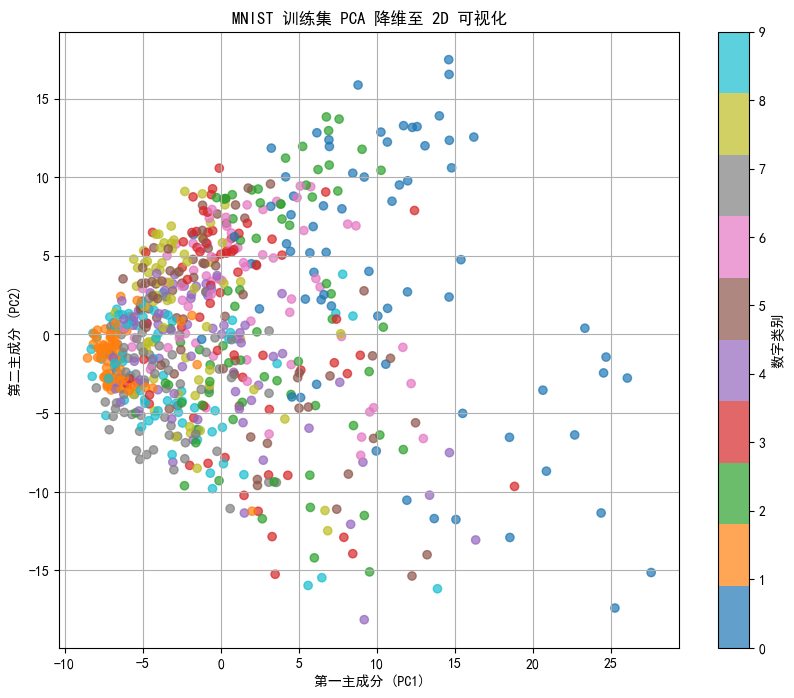

In [5]:
# --- 3.1 降维可视化 (降至 2 维) ---

# 1. 初始化 PCA (只保留 2 个成分)
pca_2d = PCA(n_components=2, random_state=42)

# 2. 在训练集上拟合和转换
X_train_2d = pca_2d.fit_transform(X_train_scaled)

print(f"已降维至 2D，形状: {X_train_2d.shape}")

# 3. 绘制 2D 散点图
plt.figure(figsize=(10, 8))
# 使用 c=y_train (数字标签 0-9) 来自动着色
# cmap='tab10' 是一个适合 10 个类别的色板
scatter = plt.scatter(
    X_train_2d[:, 0], # 第一个主成分 (PC1)
    X_train_2d[:, 1], # 第二个主成分 (PC2)
    c=y_train, 
    cmap='tab10', 
    alpha=0.7
)

plt.title('MNIST 训练集 PCA 降维至 2D 可视化')
plt.xlabel('第一主成分 (PC1)')
plt.ylabel('第二主成分 (PC2)')
plt.grid(True)
# 添加一个颜色图例 (colorbar)
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('数字类别')

plt.show()

In [7]:
# --- 3.2 分类性能对比 (PCA vs 原始数据) ---

# 我们使用刚才计算出的 n_components_95 (保留 95% 方差的主成分数)
# 在你的上一步结果中，这个值是 169
n_components_95 = 169 # 直接使用你之前得到的结果
print(f"开始对比... 将使用 {n_components_95} 维的 PCA 数据。")

# --- 1. 在 95% 方差的 PCA 数据上训练 ---
print("\n--- 训练模型 1: SVM on PCA-Reduced Data ---")

# 1.1 初始化 PCA (使用 95% 方差的主成分数)
pca_95 = PCA(n_components=n_components_95, random_state=42)

# 1.2 拟合训练集，并转换训练集和测试集
X_train_pca = pca_95.fit_transform(X_train_scaled)
X_test_pca = pca_95.transform(X_test_scaled)

print(f"PCA 数据形状: 训练集 {X_train_pca.shape}, 测试集 {X_test_pca.shape}")

# 1.3 训练 SVM
svm_pca = SVC(kernel='rbf', random_state=42) # 使用 RBF 核 SVM

start_time_pca = time.time() # 记录开始时间
svm_pca.fit(X_train_pca, y_train)
end_time_pca = time.time() # 记录结束时间

time_pca = end_time_pca - start_time_pca
acc_pca = svm_pca.score(X_test_pca, y_test)

# --- 2. 在原始 784 维数据上训练 ---
print("\n--- 训练模型 2: SVM on Original (784D) Data ---")

# 2.1 训练 SVM
svm_orig = SVC(kernel='rbf', random_state=42)

start_time_orig = time.time() # 记录开始时间
svm_orig.fit(X_train_scaled, y_train)
end_time_orig = time.time() # 记录结束时间

time_orig = end_time_orig - start_time_orig
acc_orig = svm_orig.score(X_test_scaled, y_test)

# --- 3. 打印对比结果 ---
print("\n" + "="*30)
print("     实验结果对比 (SVM on Test Set)")
print("="*30)
print(f"        | 原始数据 (784-D) | PCA 数据 ({n_components_95}-D)")
print(f"--------|--------------------|-----------------")
print(f"准确率  | {acc_orig:<18.4f} | {acc_pca:<15.4f}")
print(f"训练时间| {time_orig:<18.4f}s | {time_pca:<15.4f}s")
print("="*30)

开始对比... 将使用 169 维的 PCA 数据。

--- 训练模型 1: SVM on PCA-Reduced Data ---
PCA 数据形状: 训练集 (700, 169), 测试集 (300, 169)

--- 训练模型 2: SVM on Original (784D) Data ---

     实验结果对比 (SVM on Test Set)
        | 原始数据 (784-D) | PCA 数据 (169-D)
--------|--------------------|-----------------
准确率  | 0.8467             | 0.8833         
训练时间| 0.1903            s | 0.0818         s
